# Hyperlocal Forecasting with the Theta Method & FBProphet

In [ ]:
%%capture
!pip3 install fbprophet scipy==1.2 --upgrade

In [ ]:
import math
import datetime

import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.linear_model import LinearRegression, Ridge, HuberRegressor
from sklearn.metrics import mean_squared_error

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

import _pickle as cPickle

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import animation
sns.set(style="whitegrid")

## The Data

### Load the preprocessed data

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
cd '/content/gdrive/My Drive/Colab Notebooks/aiforsea'

/content/gdrive/My Drive/Colab Notebooks/aiforsea


In [5]:
df = pd.read_csv('full_data.csv')
df.head()

,geohash6,day,demand,in_raw,weekday,hour,minutes,ds,latitude,longitude
0,qp02yc,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.653687
1,qp02z1,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.664673
2,qp02z3,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.675659
3,qp02z9,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.686646
4,qp02zc,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.697632


### Add info for FBProphet

In [6]:
%%time
df['is_weekend'] = (4 <= (df['day'].values % 7 )) & ((df['day'].values % 7) <= 5)
df['is_weekday'] = ~(df['is_weekend'])

CPU times: user 198 ms, sys: 3.33 ms, total: 201 ms
Wall time: 202 ms


In [ ]:
df['cap']   = 1.0
df['floor'] = 0.0

In [8]:
df.head()

,geohash6,day,demand,in_raw,weekday,hour,minutes,ds,latitude,longitude,is_weekend,is_weekday,cap,floor
0,qp02yc,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.653687,False,True,1.0,0.0
1,qp02z1,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.664673,False,True,1.0,0.0
2,qp02z3,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.675659,False,True,1.0,0.0
3,qp02z9,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.686646,False,True,1.0,0.0
4,qp02zc,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.697632,False,True,1.0,0.0


### Get data for a certain location

In [ ]:
location = 'qp09d2' # 'qp09t7' # 'qp09ut' # 'qp02zg' # 'qp096w'

In [53]:
df_loc = df[(pd.to_datetime('1900-01-31 00:00:00') <= pd.to_datetime(df['ds'])) &
            (pd.to_datetime(df['ds']) <= pd.to_datetime('1900-02-13 05:30:00')) &
            (df['geohash6'] == location)].reset_index().drop('index', axis=1)
df_loc = df_loc.rename(columns={'demand' : 'y'}).drop(['geohash6', 'in_raw',
                                                     'weekday', 'hour', 'minutes',
                                                     'latitude', 'longitude'], axis=1)
df_loc.tail()

,day,y,ds,is_weekend,is_weekday,cap,floor
1266,44,1.0,1900-02-13 04:30:00,False,True,1.0,0.0
1267,44,1.0,1900-02-13 04:45:00,False,True,1.0,0.0
1268,44,1.0,1900-02-13 05:00:00,False,True,1.0,0.0
1269,44,1.0,1900-02-13 05:15:00,False,True,1.0,0.0
1270,44,1.0,1900-02-13 05:30:00,False,True,1.0,0.0


### Train-test split

In [ ]:
df_train = df_loc.iloc[:-5]
df_test  = df_loc.iloc[-5:]

## The Theta Method

### Decompose into trend and seasonality

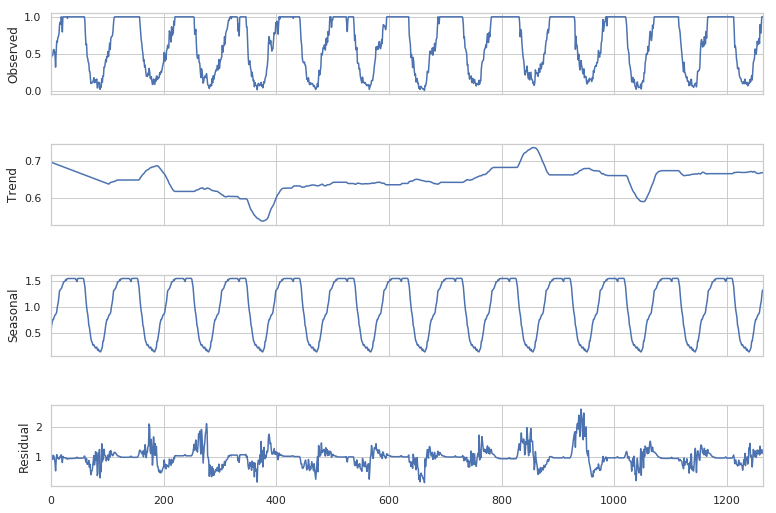

In [55]:
decomposition = sm.tsa.seasonal_decompose(df_train['y'] + 1e-18,
                                          model='multiplicative',
                                          freq=4*24,
                                          two_sided=False,
                                          extrapolate_trend=1)
fig = decomposition.plot()
fig.set_figheight(8)
fig.set_figwidth(12)
plt.show()

### Deseasonalize

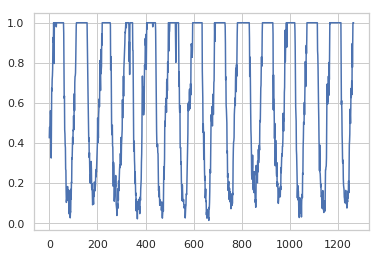

In [56]:
plt.plot(df_train['y'].values)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



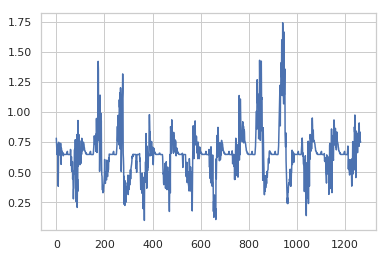

In [57]:
df_train['deseasonalized'] = df_train['y'].values / decomposition.seasonal
plt.plot(df_train['deseasonalized'])

### Prepare train and test sets

In [ ]:
X_train = np.arange(len(df_train)).reshape(-1, 1)
X_test  = (np.arange(5) + len(df_train)).reshape(-1, 1)

seasonal_test = decomposition.seasonal.values[-4*24:-4*24+5]

### Forecast using data from previous cycle

In [ ]:
yprev_pred = df_train['y'].values[-4*24: -4*24+5]

In [23]:
rmse = math.sqrt(mean_squared_error(yprev_pred, df_test['y'].values))
print("root_mean_squared_error:", rmse)

root_mean_squared_error: 0.0


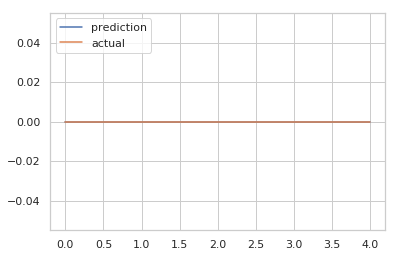

In [24]:
plt.plot(yprev_pred, label='prediction')
plt.plot(df_test['y'].values, label='actual')
plt.legend(loc='upper left')

### Theta = 0 (w/ linear regression)

In [ ]:
linreg = HuberRegressor().fit(X_train, df_train['deseasonalized'].values)

In [26]:
theta0_pred = linreg.predict(X_test)
y0_pred = np.clip(theta0_pred * seasonal_test, a_min=0.0, a_max=1.0)
y0_pred

array([0., 0., 0., 0., 0.])

In [27]:
rmse = math.sqrt(mean_squared_error(y0_pred, df_test['y'].values))
print("root_mean_squared_error:", rmse)

root_mean_squared_error: 0.0


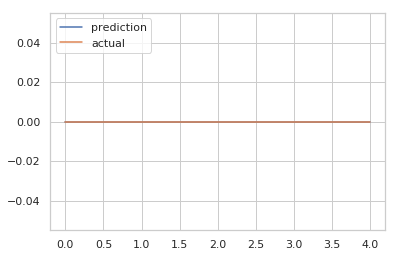

In [28]:
plt.plot(y0_pred, label='prediction')
plt.plot(df_test['y'].values, label='actual')
plt.legend(loc='upper left')

### Theta = 2 (w/ exponential smoothing)

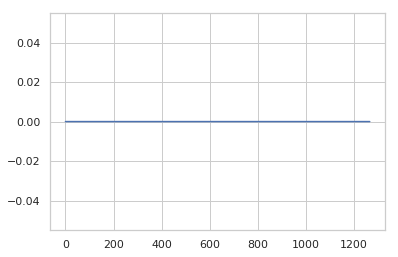

In [29]:
y_theta2 = 2*df_train['deseasonalized'].values - linreg.predict(X_train)
plt.plot(y_theta2)

In [34]:
%%time
#ses = ExponentialSmoothing(np.clip(y_theta2, 1e-9, 1.0), trend='add', damped=True).fit()
ses = SimpleExpSmoothing(np.clip(y_theta2, 1e-9, 1.0)).fit()
theta2_pred = ses.forecast(5)
y2_pred = np.clip(theta2_pred * seasonal_test, a_min=0.0, a_max=1.0)
print(y2_pred)

[1.e-09 1.e-09 1.e-09 1.e-09 1.e-09]
CPU times: user 26.5 ms, sys: 2.7 ms, total: 29.2 ms
Wall time: 31.4 ms


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:734: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:736: RuntimeWarning:

divide by zero encountered in log



In [35]:
rmse = math.sqrt(mean_squared_error(y2_pred, df_test['y'].values))
print("root_mean_squared_error:", rmse)

root_mean_squared_error: 9.999999999999996e-10


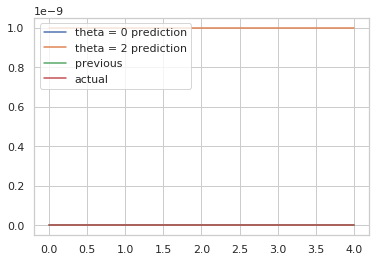

In [36]:
plt.plot(y0_pred, label='theta = 0 prediction')
plt.plot(y2_pred, label='theta = 2 prediction')
plt.plot(yprev_pred, label='previous')
plt.plot(df_test['y'].values, label='actual')
plt.legend(loc='upper left')

### Weighted theta

In [ ]:
weighted1_theta_pred = np.clip((y0_pred + y2_pred)/2.0, a_min=0.0, a_max=1.0)

In [ ]:
weighted2_theta_pred = np.clip((yprev_pred + y0_pred + y2_pred)/3.0, a_min=0.0, a_max=1.0)

In [39]:
rmse = math.sqrt(mean_squared_error(weighted1_theta_pred, df_test['y'].values))
print("root_mean_squared_error:", rmse)

root_mean_squared_error: 4.999999999999998e-10


In [40]:
rmse = math.sqrt(mean_squared_error(weighted2_theta_pred, df_test['y'].values))
print("root_mean_squared_error:", rmse)

root_mean_squared_error: 3.333333333333332e-10


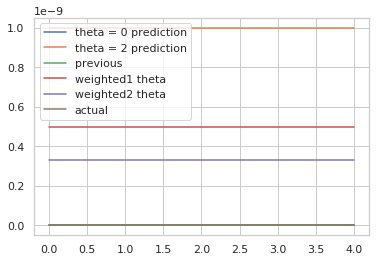

In [41]:
plt.plot(y0_pred, label='theta = 0 prediction')
plt.plot(y2_pred, label='theta = 2 prediction')
plt.plot(yprev_pred, label='previous')
plt.plot(weighted1_theta_pred, label='weighted1 theta')
plt.plot(weighted2_theta_pred, label='weighted2 theta')
plt.plot(df_test['y'].values, label='actual')
plt.legend(loc='upper left')

## FBProphet

### Create model

In [42]:
m1 = Prophet(seasonality_mode='multiplicative')

m1.fit(df_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [44]:
m2 = Prophet(
        growth='logistic',
        seasonality_mode='additive',
        daily_seasonality=False,
        uncertainty_samples=1000
    ).add_seasonality(
        name='weekday_daily',
        period=1,
        fourier_order=12,
        condition_name='is_weekday'
    ).add_seasonality(
        name='weekend_daily',
        period=1,
        fourier_order=12,
        condition_name='is_weekend'
    )

m2.fit(df_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


### Forecast

In [45]:
def is_weekend(day):
    if type(day) != int:
        day = int(pd.to_datetime(day).day)
    day %= 7
    return (4 <= day <= 5)

future = m1.make_future_dataframe(periods=5, freq='15min', include_history=False)
  
future['is_weekend'] = future['ds'].apply(is_weekend)
future['is_weekday'] = ~future['ds'].apply(is_weekend)

future['cap'] = 1.0
future['floor'] = 0.0

future.tail()

,ds,is_weekend,is_weekday,cap,floor
0,1900-02-13 04:30:00,False,True,1.0,0.0
1,1900-02-13 04:45:00,False,True,1.0,0.0
2,1900-02-13 05:00:00,False,True,1.0,0.0
3,1900-02-13 05:15:00,False,True,1.0,0.0
4,1900-02-13 05:30:00,False,True,1.0,0.0


In [46]:
forecast1 = m1.predict(future)
forecast1['yhat'] = np.clip(forecast1['yhat'].values, a_min=0.0, a_max=1.0)
forecast1['yhat_lower'] = np.clip(forecast1['yhat'].values, a_min=0.0, a_max=1.0)
forecast1['yhat_upper'] = np.clip(forecast1['yhat'].values, a_min=0.0, a_max=1.0)
forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,1900-02-13 04:30:00,0.0,0.0,0.0
1,1900-02-13 04:45:00,0.0,0.0,0.0
2,1900-02-13 05:00:00,0.0,0.0,0.0
3,1900-02-13 05:15:00,0.0,0.0,0.0
4,1900-02-13 05:30:00,0.0,0.0,0.0


In [47]:
forecast2 = m2.predict(future)
forecast2['yhat'] = np.clip(forecast2['yhat'].values, a_min=0.0, a_max=1.0)
forecast2['yhat_lower'] = np.clip(forecast2['yhat'].values, a_min=0.0, a_max=1.0)
forecast2['yhat_upper'] = np.clip(forecast2['yhat'].values, a_min=0.0, a_max=1.0)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,1900-02-13 04:30:00,5.810813e-14,5.810813e-14,5.810813e-14
1,1900-02-13 04:45:00,5.953014e-14,5.953014e-14,5.953014e-14
2,1900-02-13 05:00:00,6.058098e-14,6.058098e-14,6.058098e-14
3,1900-02-13 05:15:00,6.109949e-14,6.109949e-14,6.109949e-14
4,1900-02-13 05:30:00,6.110763e-14,6.110763e-14,6.110763e-14


In [48]:
rmse = math.sqrt(mean_squared_error(forecast1['yhat'].values, df_test['y'].values))
print("root_mean_squared_error:", rmse)

root_mean_squared_error: 0.0


In [49]:
rmse = math.sqrt(mean_squared_error(forecast2['yhat'].values, df_test['y'].values))
print("root_mean_squared_error:", rmse)

root_mean_squared_error: 6.009615098948024e-14


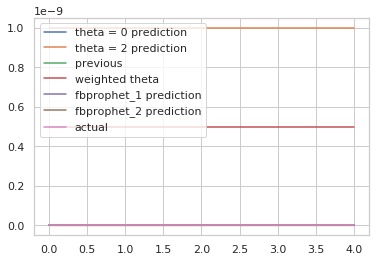

In [50]:
plt.plot(y0_pred, label='theta = 0 prediction')
plt.plot(y2_pred, label='theta = 2 prediction')
plt.plot(yprev_pred, label='previous')
plt.plot(weighted1_theta_pred, label='weighted theta')
plt.plot(forecast1['yhat'].values, label='fbprophet_1 prediction')
plt.plot(forecast2['yhat'].values, label='fbprophet_2 prediction')
plt.plot(df_test['y'].values, label='actual')
plt.legend(loc='upper left')

### Compare results

In [51]:
prev_rmse = math.sqrt(mean_squared_error(yprev_pred, df_test['y'].values))
theta0_rmse = math.sqrt(mean_squared_error(y0_pred, df_test['y'].values))
theta2_rmse = math.sqrt(mean_squared_error(y2_pred, df_test['y'].values))
weighted1_rmse = math.sqrt(mean_squared_error(weighted1_theta_pred, df_test['y'].values))
weighted2_rmse = math.sqrt(mean_squared_error(weighted2_theta_pred, df_test['y'].values))
fbprophet1_rmse = math.sqrt(mean_squared_error(forecast1['yhat'].values, df_test['y'].values))
fbprophet2_rmse = math.sqrt(mean_squared_error(forecast2['yhat'].values, df_test['y'].values))
all1_rmse = math.sqrt(mean_squared_error((forecast1['yhat'].values + 2*weighted1_theta_pred)/3.0, df_test['y'].values))
all2_rmse = math.sqrt(mean_squared_error((forecast2['yhat'].values + 2*weighted1_theta_pred)/3.0, df_test['y'].values))
all3_rmse = math.sqrt(mean_squared_error((forecast1['yhat'].values + forecast2['yhat'].values + 2*weighted1_theta_pred)/4.0, df_test['y'].values))
print("prev cycle rmse:", prev_rmse)
print("theta=0 rmse:", theta0_rmse)
print("theta=2 rmse:", theta2_rmse)
print("weighted1 theta rmse:", weighted1_rmse)
print("weighted2 theta rmse:", weighted2_rmse)
print("prophet1_rmse:", fbprophet1_rmse)
print("prophet2_rmse:", fbprophet2_rmse)
print("all1_rmse:", all1_rmse)
print("all2_rmse:", all2_rmse)
print("all3_rmse:", all3_rmse)

prev cycle rmse: 0.0
theta=0 rmse: 0.0
theta=2 rmse: 9.999999999999996e-10
weighted1 theta rmse: 4.999999999999998e-10
weighted2 theta rmse: 3.333333333333332e-10
prophet1_rmse: 0.0
prophet2_rmse: 6.009615098948024e-14
all1_rmse: 3.333333333333332e-10
all2_rmse: 3.3335336175777014e-10
all3_rmse: 2.5001502131832766e-10
